In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from sae_lens import SAE

/cs/student/projects2/aisd/2024/seongcho/miniconda3/envs/sae/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.backends.mps.is_available() else device

In [19]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
llm = AutoModelForCausalLM.from_pretrained("gpt2").to(device)
llm.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [20]:
llm.transformer.wpe

Embedding(1024, 768)

In [21]:
def zero_hook(module, inputs, outputs):
    """
    Simple version of a steering hook. Adds a weighted vector
    to the residual. Customize if needed.
    """
    embedding = outputs[0]
    zero = torch.zeros_like(embedding).unsqueeze(0)
    return zero

llm.transformer.wte.register_forward_hook(zero_hook)

In [22]:
models_config = {
    "gpt2": {
        "id": "gpt2",
        "sae": "jbloom/GPT2-Small-SAEs-Reformatted",
        "hooks": [
            "blocks.11.hook_resid_pre"
        ]
    }
}

In [23]:
sae_models = {}
hooks = models_config["gpt2"]["hooks"]
for hook in hooks:
    sae, _, _ = SAE.from_pretrained(models_config["gpt2"]["sae"], hook, device=device)
    sae_models[hook] = sae

In [24]:
sae_models["blocks.11.hook_resid_pre"]

SAE(
  (activation_fn): ReLU()
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_sae_acts_post): HookPoint()
  (hook_sae_output): HookPoint()
  (hook_sae_recons): HookPoint()
  (hook_sae_error): HookPoint()
)

In [25]:
sae_models["blocks.11.hook_resid_pre"].cfg

SAEConfig(architecture='standard', d_in=768, d_sae=24576, activation_fn_str='relu', apply_b_dec_to_input=True, finetuning_scaling_factor=False, context_size=128, model_name='gpt2-small', hook_name='blocks.11.hook_resid_pre', hook_layer=11, hook_head_index=None, prepend_bos=True, dataset_path='Skylion007/openwebtext', dataset_trust_remote_code=True, normalize_activations='none', dtype='torch.float32', device='cuda', sae_lens_training_version=None, activation_fn_kwargs={}, neuronpedia_id=None, model_from_pretrained_kwargs={}, seqpos_slice=(None,))

In [26]:
from datasets import load_dataset

In [27]:
pile = load_dataset("NeelNanda/pile-10k", split="train")

In [28]:
from transformer_lens.utils import tokenize_and_concatenate

token_dataset = tokenize_and_concatenate(
    dataset=pile,
    tokenizer=tokenizer,
    streaming=True,
    max_length=1024,
    add_bos_token=True,
)

In [29]:
def convert_token_dataset_to_tensors(dataset, device):
    def to_tensor(example):
        example["tokens"] = torch.tensor(example["tokens"]).to(device)
        return example

    tensor_dataset = dataset.map(to_tensor)
    return tensor_dataset

token_dataset = convert_token_dataset_to_tensors(token_dataset, device)

In [30]:
from concurrent.futures import ThreadPoolExecutor
import numpy as np
from tqdm import tqdm

def process_hook(hook, hidden_state, sae_models):
    # Process the hidden state through the SAE model
    activations = sae_models[hook].encode(hidden_state)
    # Remove the batch dimension (assumes batch size = 1) and move to CPU
    activations = activations.to(torch.float16).detach().cpu().numpy()  # (seq_len, num_features)
    return hook, activations

def extract_activations_parallel(tokens_list, hooks, sae_models, llm):
    features_by_hook = {hook: [] for hook in hooks}
    
    for encoding in tqdm(tokens_list, desc="Extracting activations"):
        with torch.no_grad():
            outputs = llm(encoding.to(device), output_hidden_states=True)
            
            # Use ThreadPoolExecutor to process hooks in parallel
            with ThreadPoolExecutor(max_workers=len(hooks)) as executor:
                futures = []
                for hook in hooks:
                    # Parse layer index from the hook string
                    layer = int(hook.split(".")[1])
                    hidden_state = outputs.hidden_states[layer]  # shape: (batch_size, seq_len, hidden_dim)
                    # Submit tasks to the thread pool
                    futures.append(executor.submit(process_hook, hook, hidden_state, sae_models))
                
                # Gather results
                for future in futures:
                    hook, activations = future.result()
                    features_by_hook[hook].append(activations)
    
    return features_by_hook

In [31]:
features_by_hook = extract_activations_parallel(token_dataset.select(range(400))['tokens'], hooks, sae_models, llm)

Extracting activations: 100%|██████████| 400/400 [00:15<00:00, 26.48it/s]


In [32]:
# Convert lists to numpy arrays
for hook in hooks:
    features_by_hook[hook] = np.concatenate(features_by_hook[hook], axis=0)
    features_by_hook[hook] = torch.Tensor(features_by_hook[hook])

In [ ]:
def compute_token_stat(features_by_hook, hook_name='blocks.11.hook_resid_pre', 
                       exclude_zeros=True, chunk_size=10000):
    """
    Compute token statistics: count, mean, std, and activation density.
    Activation density is the fraction of nonzero activations.
    Returns five tensors of shape (num_tokens,).
    """
    activations = features_by_hook[hook_name]
    activations = activations.transpose(0, 1).flatten(start_dim=1).to(torch.float32)
    num_tokens, total_length = activations.shape

    token_count   = torch.zeros(num_tokens, dtype=torch.int64, device=activations.device)
    token_sum     = torch.zeros(num_tokens, dtype=torch.float32, device=activations.device)
    token_sq_sum  = torch.zeros(num_tokens, dtype=torch.float32, device=activations.device)

    for i in range(0, total_length, chunk_size):
        chunk = activations[:, i:i+chunk_size]
        if exclude_zeros:
            mask = (chunk != 0)
            mask_float = mask.to(torch.float32)
            token_sum    += torch.sum(chunk * mask_float, dim=1)
            token_count  += torch.sum(mask, dim=1)
            token_sq_sum += torch.sum((chunk ** 2) * mask_float, dim=1)
        else:
            token_sum    += torch.sum(chunk, dim=1)
            token_count  += chunk.size(1)
            token_sq_sum += torch.sum(chunk ** 2, dim=1)

    token_count_clamped = torch.clamp(token_count, min=1)
    token_mean = token_sum / token_count_clamped
    token_variance = token_sq_sum / token_count_clamped - token_mean ** 2
    token_std = torch.sqrt(token_variance)

    # Activation density: fraction of nonzero activations
    token_density = token_count.to(torch.float32) / total_length

    return token_count, token_mean, token_std, token_density


def compute_feature_stat(features_by_hook, hook_name='blocks.11.hook_resid_pre', 
                         exclude_zeros=True, chunk_size=1000, ignore_first=True):
    """
    Compute feature statistics: count, mean, std, median, and activation density.
    Activation density is the fraction of nonzero activations.
    Returns five tensors of shape (num_features,).
    """
    activations = features_by_hook[hook_name]
    if ignore_first:
        activations = activations[:, 1:, :]
    activations = activations.transpose(0, 2).flatten(start_dim=1).to(torch.float32)
    num_features, total_length = activations.shape

    feature_count   = torch.zeros(num_features, dtype=torch.int64, device=activations.device)
    feature_sum     = torch.zeros(num_features, dtype=torch.float32, device=activations.device)
    feature_sq_sum  = torch.zeros(num_features, dtype=torch.float32, device=activations.device)

    for i in range(0, total_length, chunk_size):
        chunk = activations[:, i:i+chunk_size]
        if exclude_zeros:
            mask = (chunk != 0)
            mask_float = mask.to(torch.float32)
            feature_sum    += torch.sum(chunk * mask_float, dim=1)
            feature_count  += torch.sum(mask, dim=1)
            feature_sq_sum += torch.sum((chunk ** 2) * mask_float, dim=1)
        else:
            feature_sum    += torch.sum(chunk, dim=1)
            feature_count  += chunk.size(1)
            feature_sq_sum += torch.sum(chunk ** 2, dim=1)

    feature_count_clamped = torch.clamp(feature_count, min=1)
    feature_mean = feature_sum / feature_count_clamped
    feature_variance = feature_sq_sum / feature_count_clamped - feature_mean ** 2
    feature_std = torch.sqrt(feature_variance)

    feature_density = feature_count.to(torch.float32) / total_length

    return feature_count, feature_mean, feature_std, feature_density


In [34]:
token_count, token_mean, token_std, token_density = compute_token_stat(features_by_hook)

In [35]:
feature_count, feature_mean, feature_std, feature_density = compute_feature_stat(features_by_hook)

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_distribution(data, title, xlabel, ylabel='Activation', color='blue', plot_type='line', log_scale=False, monoton=False, size=20):
    plt.figure(figsize=(12, 6))
    x = np.arange(len(data))
    
    if plot_type == 'line':
        colors = np.linspace(0, 1, len(data))
        cmap = sns.color_palette("flare", as_cmap=True)
        plt.plot(x, data, color='grey', linewidth=1, alpha=0.5)
        plt.scatter(x, data, c=colors, cmap=cmap, s=size)
        
    elif plot_type == 'histogram':
        sns.histplot(data, bins=50, kde=True, color=color)
        
    elif plot_type == 'scatter':
        colors = np.linspace(0, 1, len(data))
        if monoton:
            colors = sns.color_palette("mako")[0]
            plt.scatter(x, data, color=colors, s=size)
        else:
            cmap = sns.color_palette("viridis", as_cmap=True)
            plt.scatter(x, data, c=colors, cmap=cmap, s=size)
        
    else:
        raise ValueError("Invalid plot_type. Choose 'line', 'histogram', or 'scatter'.")
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if log_scale:
        plt.yscale('log')
        
    plt.grid(False)
    plt.show()

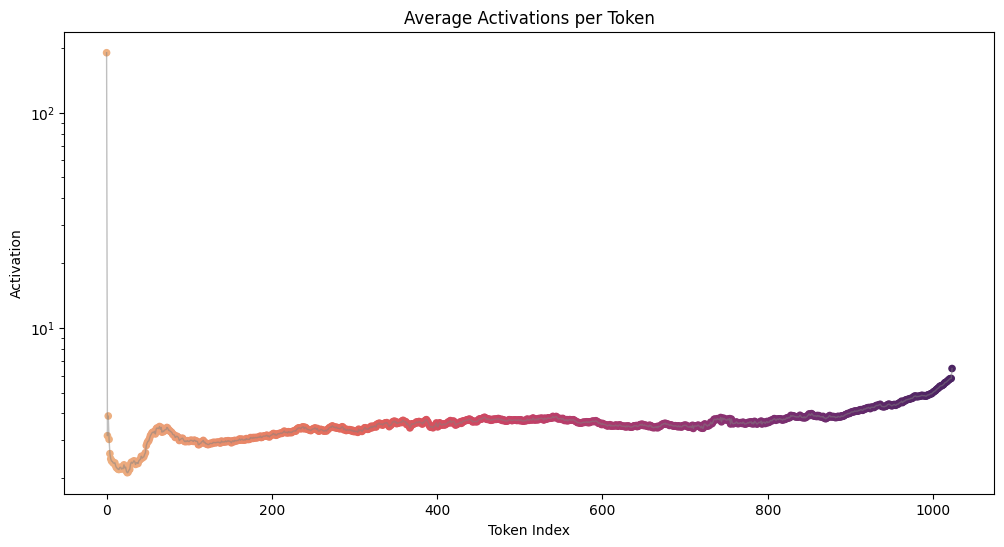

In [37]:
visualize_distribution(token_mean, 'Average Activations per Token', 'Token Index', log_scale=True) # и

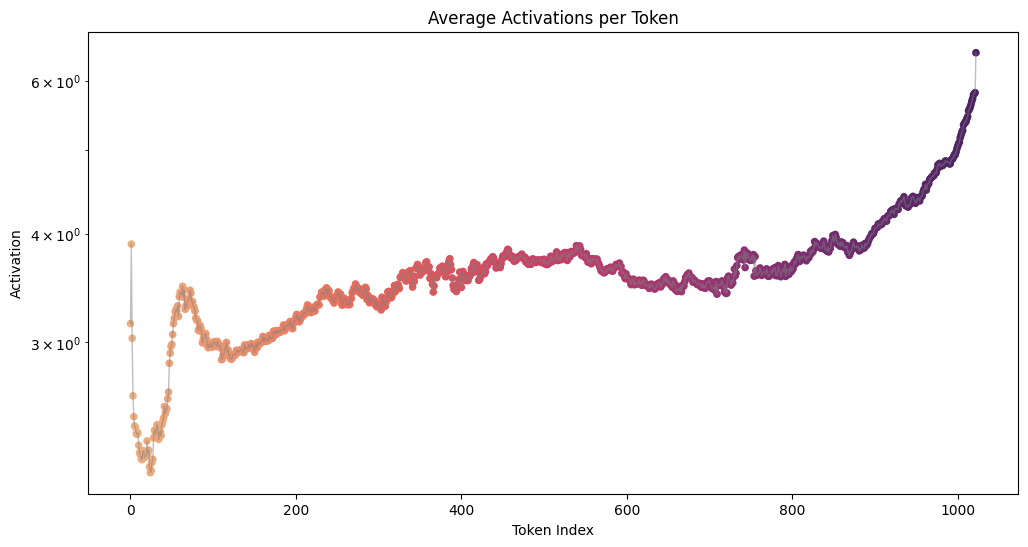

In [41]:
visualize_distribution(token_mean[1:], 'Average Activations per Token', 'Token Index', log_scale=True) # и

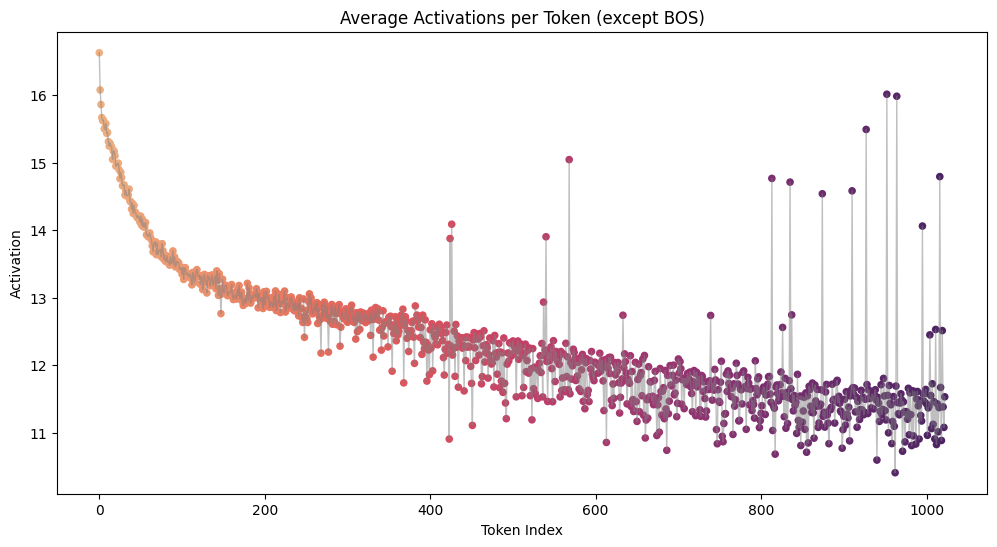

In [59]:
visualize_distribution(token_mean[1:], 'Average Activations per Token (except BOS)', 'Token Index', log_scale=False)

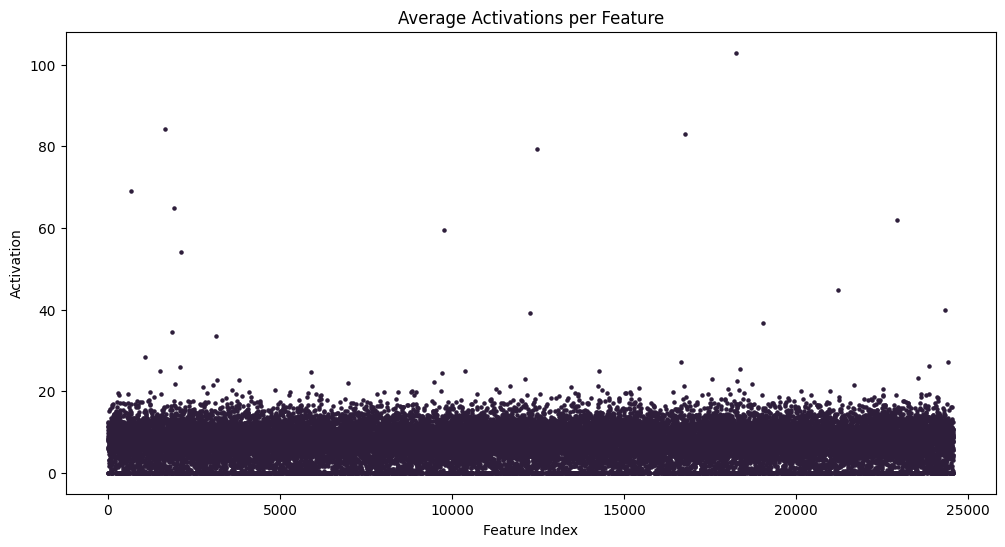

In [60]:
visualize_distribution(feature_mean, 'Average Activations per Feature', 'Feature Index', log_scale=False, plot_type='scatter', monoton=True, size=5)

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_avg_std(avg, std, log_scale=True, type='Token', monoton=False, index=True):
    plt.figure(figsize=(10, 6))
    
    avg_np = avg.cpu().numpy()
    std_np = std.cpu().numpy()
    num_points = len(avg_np)
    
    # Use actual indices as color values.
    colors = np.arange(num_points)
    cmap = sns.color_palette("flare", as_cmap=True)
    if monoton:
        colors = sns.color_palette("mako")[0]
        scatter = plt.scatter(avg_np, std_np, color=colors, s=5)
    else:
        scatter = plt.scatter(avg_np, std_np, c=colors, cmap=cmap, s=5)
    
    plt.xlabel('Activation Average')
    plt.ylabel('Standard Deviation of Activations')
    
    if log_scale:
        plt.xscale('log')
        plt.yscale('log')
        
    plt.title(f'{type} Average vs. {type} Standard Deviation')
    plt.grid(False)
    
    # Create colorbar with actual indices.
    if index:
      cbar = plt.colorbar(scatter)
      cbar.set_label(f'{type} Index')
      # Set colorbar ticks to reflect actual indices.
      tick_locs = np.linspace(0, num_points - 1, min(num_points, 10))
      cbar.set_ticks(tick_locs)
      cbar.set_ticklabels([str(int(x)) for x in tick_locs])
    
    # Annotate points where average > 100 with their actual index.
    for i in range(num_points):
        if avg_np[i] > 100:
            plt.annotate(str(i), (avg_np[i], std_np[i]),
                         textcoords="offset points", xytext=(5, 5),
                         fontsize=8, color='navy')
    
    plt.show()


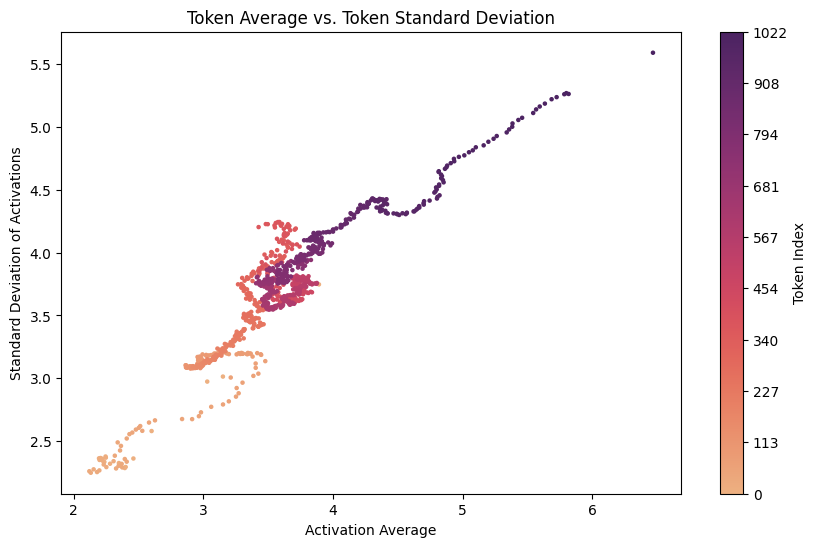

In [40]:
visualize_avg_std(token_mean[1:], token_std[1:], log_scale=False)

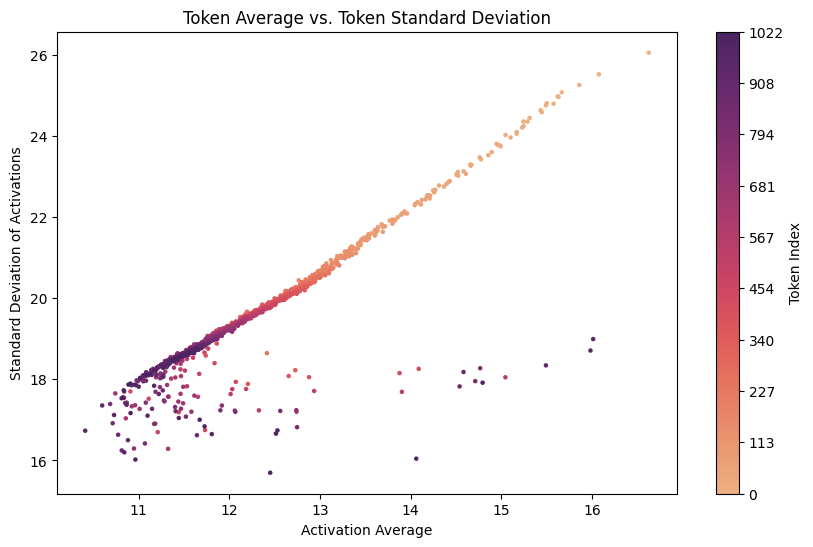

In [ ]:
visualize_avg_std(token_mean[1:], token_std[1:], log_scale=False)

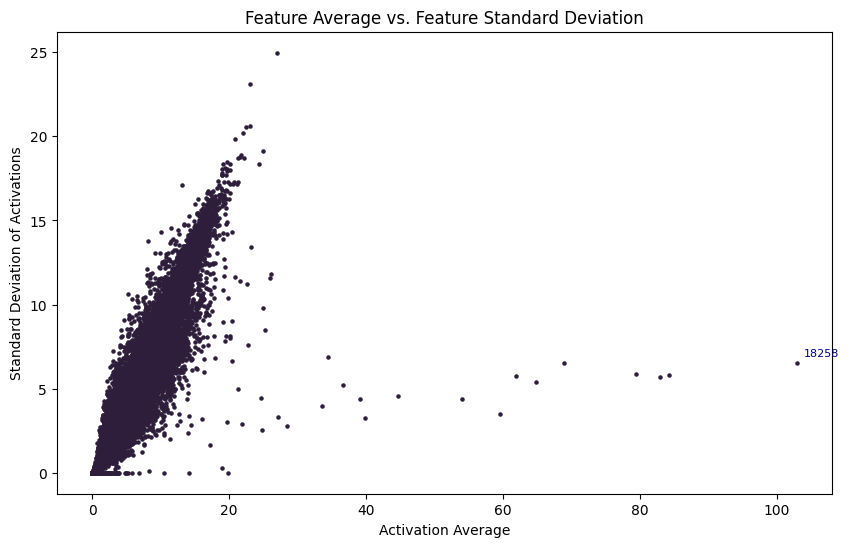

In [66]:
visualize_avg_std(feature_mean, feature_std, log_scale=False, type='Feature', monoton=True, index=False)

In [67]:
def compute_quantiles(features_by_hook, hook_name='blocks.11.hook_resid_pre', level=10, ignore_first=True):
    """
    Compute quantiles for each feature individually.
    Returns a numpy array of shape (num_features, level).
    """
    activations = features_by_hook[hook_name][:, 1 if ignore_first else 0:, :]
    # for tqtm nonzero flatten
    feature_count = activations.shape[2]
    feature_quantiles = []
    for i in tqdm(range(feature_count), desc="Computing quantiles"):
        feature_activations = activations[:, :, i].flatten()
        feature_activations = feature_activations[feature_activations != 0]
        if feature_activations.size(0) == 0:
            feature_quantiles.append(torch.zeros(level))
            continue
        feature_quantile = torch.quantile(feature_activations, torch.linspace(0, 1, level + 1)[1:])
        feature_quantiles.append(feature_quantile)
    return torch.stack(feature_quantiles)

In [68]:
# Compute quantiles
quantiles = compute_quantiles(features_by_hook, level=10)

Computing quantiles: 100%|██████████| 24576/24576 [00:48<00:00, 511.28it/s]


In [69]:
feature_median = quantiles[:, 4]

In [70]:
import pandas as pd

def visualize_quantiles_line(quantiles, log_scale=True):
    num_features, num_quantiles = quantiles.shape
    q_levels = np.linspace(1, 10, num_quantiles - 1)

    # Reshape data into long format for seaborn
    data = []
    for i in reversed(range(1, num_quantiles)):
        quantile_label = f"Decile {q_levels[i-1]:.0f}"
        for j in range(num_features):
            data.append({
                "Feature": j,
                "Activation": float(quantiles[j, i]),
                "Quantile Level": quantile_label
            })
    df = pd.DataFrame(data)
    
    plt.figure(figsize=(12, 8))
    sns.lineplot(
        data=df, x="Feature", y="Activation", hue="Quantile Level",
        palette="mako", linewidth=0, marker="o", markeredgewidth=0, alpha=0.7
    )
    
    plt.xlabel("Feature Index")
    if log_scale:
        plt.yscale('log')
        plt.ylabel("Log Activation Value")
    else:
        plt.ylabel("Activation Value")
    plt.title("Quantiles per Feature")
    plt.grid(False)
    plt.legend(title="Quantile Level")

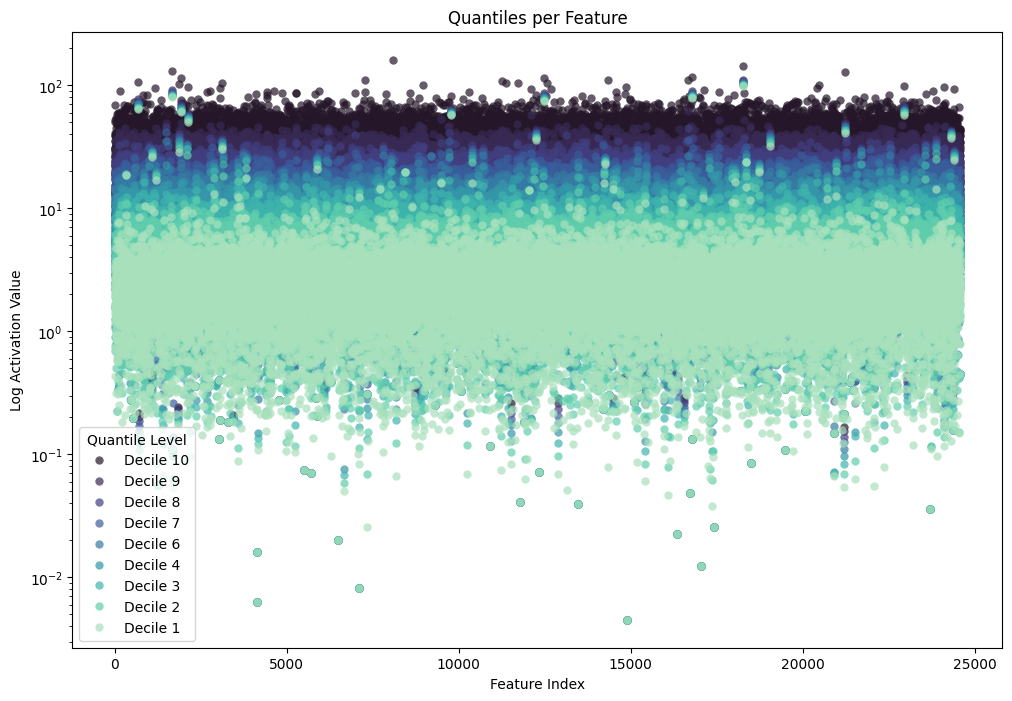

In [76]:
visualize_quantiles_line(quantiles)

In [77]:
# Compute quantiles
quantiles_with_first = compute_quantiles(features_by_hook, level=10, ignore_first=False)

Computing quantiles: 100%|██████████| 24576/24576 [00:42<00:00, 573.80it/s]


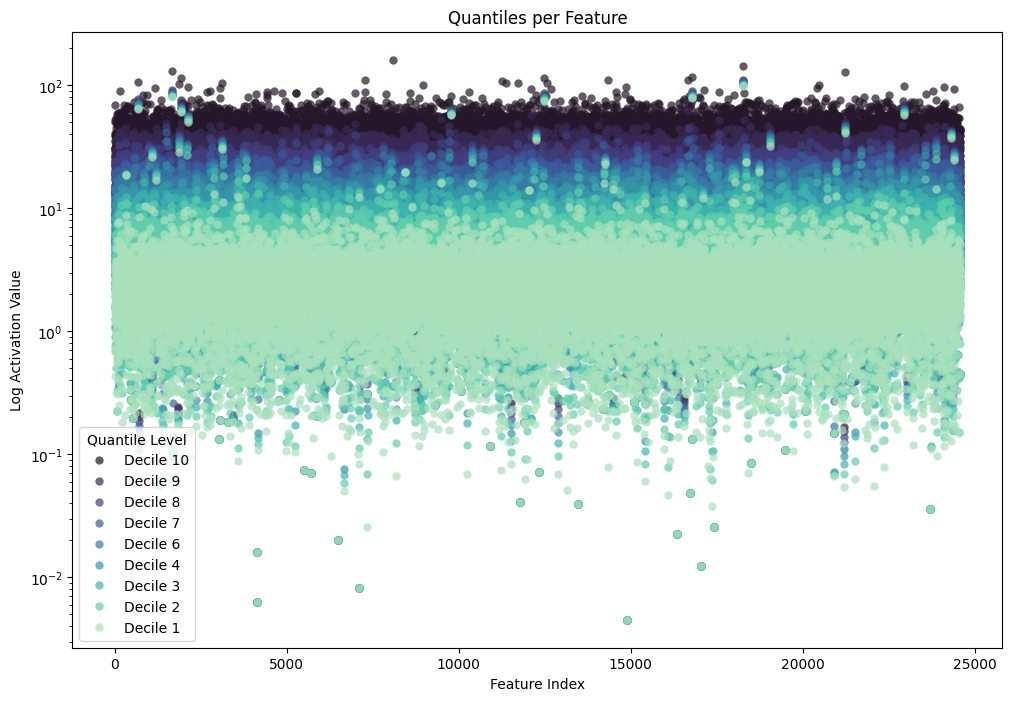

In [78]:
visualize_quantiles_line(quantiles_with_first)